In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import time
from torch.optim import lr_scheduler

from torch.utils.data import Dataset
from torch.utils.data import random_split

from torchvision import transforms, models
from MyEDFImports import load_all_labels, stages_names_3_outputs, three_stages_transform
from tempfile import TemporaryDirectory

In [3]:
data_dir = '../images_cwt_ssq/images_(19248, 224, 224)_wav_morlet_sqpy.npy'
data_np = np.load(data_dir)
targets = load_all_labels()
targets = three_stages_transform(targets)

In [3]:
class DatasetFromNp(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        # Extending 1channel image to be put to three channels
        x = torch.from_numpy(x)
        x = torch.unsqueeze(x, 0)
        x = x.expand(3, -1, -1)
        y = self.target[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.target)


In [4]:
# setting up tranforms for the images (just normalizing pretty much)
data_transforms = transforms.Compose([
    # to tensor can probably be just torch.from_numpy
    # transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

dataset_all = DatasetFromNp(data_np, target=targets, transform=data_transforms)

generator = torch.Generator()  # .manual_seed(22)
train_data, test_data = random_split(dataset_all, [0.8, 0.2], generator=generator)
datasets = {'train': train_data, 'val': test_data}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in
               ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
# remove a fixed generator for training


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TypeError: Invalid shape (3, 228, 906) for image data

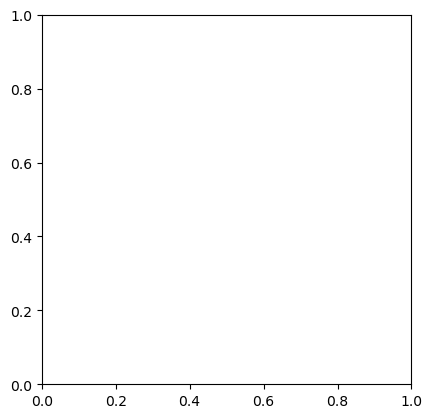

In [6]:
# this imshow should be fixed doesn't work yet
def imshow(inp, title=None):
    # inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# not necessarily test_data subset has to be there can be anything else
inputs, classes = next(iter(dataloaders['train']))
grid = torchvision.utils.make_grid(inputs)
# imshow(grid, title= classes)


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    # No idea why now for inputs why I need to transfer it to a float from a double
                    inputs = inputs.to(device, dtype=torch.float)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [9]:
model_152 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_152.fc.in_features
model_152

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
model_152.fc = nn.Linear(num_ftrs, 3)
model_152.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_152 = optim.SGD(model_152.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_152, step_size=7, gamma=0.1)

In [22]:
model_152 = train_model(model_152, criterion, optimizer_152, exp_lr_scheduler,
                        num_epochs=25)

Epoch 1/25
----------
train Loss: 0.8587 Acc: 0.6537
val Loss: 0.9394 Acc: 0.6345

Epoch 2/25
----------
train Loss: 0.7049 Acc: 0.7217
val Loss: 0.9643 Acc: 0.5310

Epoch 3/25
----------
train Loss: 0.6087 Acc: 0.7604
val Loss: 0.9421 Acc: 0.6345

Epoch 4/25
----------
train Loss: 0.5300 Acc: 0.7949
val Loss: 0.9875 Acc: 0.6261

Epoch 5/25
----------
train Loss: 0.4850 Acc: 0.8138
val Loss: 1.0176 Acc: 0.6339

Epoch 6/25
----------
train Loss: 0.4497 Acc: 0.8245
val Loss: 0.9691 Acc: 0.6345

Epoch 7/25
----------
train Loss: 0.4079 Acc: 0.8441
val Loss: 0.9163 Acc: 0.6345

Epoch 8/25
----------
train Loss: 0.3011 Acc: 0.8898
val Loss: 1.3557 Acc: 0.1839

Epoch 9/25
----------
train Loss: 0.2678 Acc: 0.8989
val Loss: 0.8414 Acc: 0.6547

Epoch 10/25
----------
train Loss: 0.2458 Acc: 0.9072
val Loss: 0.8368 Acc: 0.6581

Epoch 11/25
----------
train Loss: 0.2295 Acc: 0.9144
val Loss: 0.3117 Acc: 0.8844

Epoch 12/25
----------
train Loss: 0.2138 Acc: 0.9193
val Loss: 1.9859 Acc: 0.1855

E

In [11]:
dir_saved_models = 'saved_models'
torch.save(model_152, dir_saved_models + f'/ResNet152_16_06')

In [12]:
model_loaded = torch.load('saved_models/ResNet152_16_06')
model_loaded.to(device)
model_loaded.eval()
dl_for_all = torch.utils.data.DataLoader(dataset_all, batch_size=1, num_workers=4)
predictions = []
with torch.no_grad():
    for i, l in dl_for_all:
        i = i.to(device, dtype=torch.float32)
        l.to(device)
        all_outputs = model_loaded(i)
        predictions.append(all_outputs)

In [11]:
import gc

model_loaded.cpu()
del model_loaded
gc.collect()
torch.cuda.empty_cache()

In [11]:
torch.tensor(predictions)

ValueError: only one element tensors can be converted to Python scalars

In [6]:
len(predictions)

19248

In [21]:
prrrred = [torch.max(prediction, 1)[1] for prediction in predictions]


In [22]:
prrrred == targets

False

In [24]:
good = 0
for i in range(len(targets)):
    if targets[i] == prrrred[i]:
        good += 1
good / len(targets)

0.47604945968412304